# Predicting music genre using Convolutional Neural Networks

## A short description of the dataset

The dataset we will be using in this notebook comes from a dump of the Free Music Archive (FMA), available [in this Github repository](https://github.com/mdeff/fma). The complete description of this project may be found [in this paper](https://arxiv.org/abs/1612.01840).

To summarise, whole dataset is comprised of 106,574 of Creative Commons-licenced tracks from 16,341 artists and 14,854 albums, arranged in a hierarchical structure of 161 genres. However, in this notebook, we will be focusing on a **smaller subset** of this initial dataset: the dataset we will be focusing on will be comprised of **8,000 30 second clips**. Those clipe belong to 8 top genres, balanced with 1,000 clips per genre.

Our goal in this notebook will be to classify the genre of an unknown track among the 8 genres that are present in our dataset.

## Downloading the dataset

First of all, let's download the data that we will be using. Since the files are quite heavy (>7 GB in total), we download in the Jupyter Notebook instead of having them directly. We then unzip the content of the files.

The whole dataset is entirely in the cloud, so it removes constraints about data space or anything.

**Note: Please note that the whole process may be a bit long (~15 minutes).**


In [31]:
!curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!curl -O https://os.unil.cloud.switch.ch/fma/fma_small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341M  100  341M    0     0  16.1M      0  0:00:21  0:00:21 --:--:-- 18.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7323M  100 7323M    0     0  17.8M      0  0:06:51  0:06:51 --:--:-- 18.0M


In [32]:
!unzip fma_metadata.zip
!unzip fma_small.zip

Archive:  fma_metadata.zip
replace fma_metadata/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  fma_small.zip
replace fma_small/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

First of all, let's download the data that we will be using. Since the files are quite heavy (>7 GB in total), we download in the Jupyter Notebook instead of having them directly.

## Data exploration

In [0]:
import pandas as pd
import numpy as np
import os

The full information about the tracks, including the genre, can be found in the file `tracks.csv`. As for the genre, the according code can be retrieved in the file `genres.csv`.

In [3]:
genres = pd.read_csv('/content/fma_metadata/genres.csv')
tracks = pd.read_csv('/content/fma_metadata/tracks.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# The first two lines are a bit buggy, so we remove them 
tracks.columns = ["track_id"] + list(tracks.iloc[0])[1:]
tracks = tracks.drop(tracks.index[[0,1]])
tracks = tracks.reset_index()
tracks[:5]

,index,track_id,comments,date_created,date_released,engineer,favorites,id,information,listens,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,5,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,6,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


If we take a look at the `tracks.csv` file, we notice that there are many columns that we do not need. In fact, we only need two pieces of information: the **track_id** (in order to know to which song we are referring) and the **corresponding genre**.

In [5]:
# We reduce the dataset in order to only keep the track ID and the genre
reduced_tracks = pd.DataFrame({'track_id': tracks.track_id, 'genres': tracks.genres})
reduced_tracks.track_id = reduced_tracks.track_id.astype(int)
reduced_tracks.set_index('track_id', inplace = True) 
reduced_tracks[:10]

,genres
track_id,
2,[21]
3,[21]
5,[21]
10,[10]
20,"[76, 103]"
26,"[76, 103]"
30,"[76, 103]"
46,"[76, 103]"
48,"[76, 103]"


In [6]:
len(reduced_tracks)

106574

There is another problem: we are working on a **small subset** of an original dataset, while the metadata refers to the **entirety of the original dataset** (which explains why the previous dataset has over $100,000$ rows). For this reason, we will need to remove all the lines that refer to tracks that are not present in our sample.

### Finding the track names

In [0]:
# We iterate over all files in the `fma_small` folder, in order to get their names
file_list = []

for root, dirs, files in os.walk("/content/fma_small"):  
    file_list += [file_name for file_name in files]

file_list = file_list[2:]

In [0]:
# We then remove the '.mp3' extension and take the remaining name
track_list = []

for file_name in file_list:
  track_id = int(file_name.split('.')[0])
  track_list += [track_id]

 As a sanity check, we can see that the number of track names we have is indeed equal to the total number of tracks:

In [9]:
len(track_list)

8000

We can then use those track names to reduce the length of our dataset to the expected $8,000$ rows.

In [10]:
reduced_tracks = reduced_tracks.reindex(track_list).sort_index()
reduced_tracks[:10]

,genres
track_id,
2,[21]
5,[21]
10,[10]
140,[17]
141,[17]
148,[1]
182,[27]
190,[17]
193,[17]


### Finding the right genre
The people who have created this dataset have made it so that each song belongs to **one genre** out of **eight possible genres**. However, in this dataset, we can see that some songs have several genres attributed to them – in that case, it means that all its genres are "subsets" of a single "parent" genre.

For most rows, the "parent" genre is the first genre listed (or the only genre mentionned). However, in certain cases, we find that there are **only subgenres** that are present, and that the "parent" genre is missing.

In the end, the goal of this section is to only keep the "parent" genre, which is supposed to be unique, for every track we have in our dataset.

In [0]:
genres.top_level = genres.top_level.astype(int)
genres.genre_id = genres.genre_id.astype(int)
genres.set_index('genre_id', inplace = True)

In [0]:
def parent_genre(genre_list):
  
  """
  This is the function we apply on the `genres` column.
  We replace every genre by its parent genre (if it exists, otherwise we change nothing).
  
  Afterwards, for a given row, if all parent genres are the same, then we remove
  the list and keep the first element only.
  """
  
  genre_list = genre_list[1:-1].split(',')
  genre_list = [int(genres.loc[int(x)].top_level) if int(x) in genres.index else int(x) for x in genre_list]
  
  if len(set(genre_list)) == 1:
    return genre_list[0]
  
  else:
    return genre_list



reduced_tracks.genres = reduced_tracks.genres.apply(parent_genre, 1)

In [13]:
reduced_tracks[:10]

,genres
track_id,
2,21
5,21
10,10
140,17
141,17
148,38
182,12
190,17
193,17


Now, we just need to replace the genre code with the proper genre name.

In [14]:
reduced_tracks.genres = reduced_tracks.genres.apply(lambda x: genres.loc[x].title)
reduced_tracks[:10]

,genres
track_id,
2,Hip-Hop
5,Hip-Hop
10,Pop
140,Folk
141,Folk
148,Experimental
182,Rock
190,Folk
193,Folk


We can now save this reduced .csv file.

In [0]:
reduced_tracks.to_csv('reduced_tracks.csv')

## Track transformation

From what we have seen, a very common approach to process sound files for Genre Recognition, either with CNN or other techniques, is to turn them into a mel spectrogram. This is what we do here, thanks to Librosa.

A few interesting sources **(maybe do not include this as a final presentation)**:
- http://deepsound.io/music_genre_recognition.html
- https://arxiv.org/pdf/1802.09697.pdf
- http://cs231n.stanford.edu/reports/2017/pdfs/22.pdf
- https://medium.com/@diegoagher/learning-music-genres-5ab1cabadfed **<- THEY HAVE WORKED ON OUR DATASET**
- https://arxiv.org/pdf/1709.04396.pdf

<br/>


Note: After installing Librosa, we install ffmpeg, because otherwise Librosa does not recognise .mp3 files.

<br/>

Other note: http://lbms03.cityu.edu.hk/theses/c_ftt/mphil-cs-b39478026f.pdf is another interesting paper.

In [16]:
!pip install librosa
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


In [0]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import time

Firstly, we need to find the actual path for every song (its subdirectory + its name).

In [0]:
file_paths = []
folder_list = []

for folder in os.listdir(path='./fma_small/'):
  if len(folder) == 3:
    folder_list += [folder]
    file_paths += [folder + '/' + files for files in os.listdir('./fma_small/' + folder)]

In [0]:
def mel_spect(file_name, file_path = '/content/fma_small/'):
  
  song, sampling_rate = librosa.core.load('%s%s' % (file_path, file_name))
  song_mel = librosa.feature.melspectrogram(song, sr = sr,
                                            n_fft = fft_window_points,
                                            hop_length = hop_size, n_mels = n_mels,
                                            fmax = fmax)
  return song_mel
  

def display_spect(mel_spec):
  
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(librosa.power_to_db(mel_spec,
                                                ref=np.max),
                            y_axis='mel', fmax=8000,
                            x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel spectrogram')
  plt.tight_layout()

In [0]:
# parameters for calculating spectrogram in mel scale
sr = 22050
fmax = 10000 # maximum frequency considered
fft_window_points = 512
fft_window_dur = fft_window_points * 1.0 / sr # 23ms windows
hop_size = int(fft_window_points/ 2) # 50% overlap between consecutive frames
n_mels = 64

def mel_spectrogram(ys, sr, n_mels=n_mels, hop_size=hop_size, fmax=fmax, pre_emphasis=False):
  if pre_emphasis:
    ys = np.append(ys[0], ys[1:]-pre_emphasis*ys[:-1])
  return librosa.feature.melspectrogram(ys, sr,
                                          n_fft=fft_window_points,
                                          hop_length=hop_size, n_mels=n_mels,
                                          fmax=fmax)

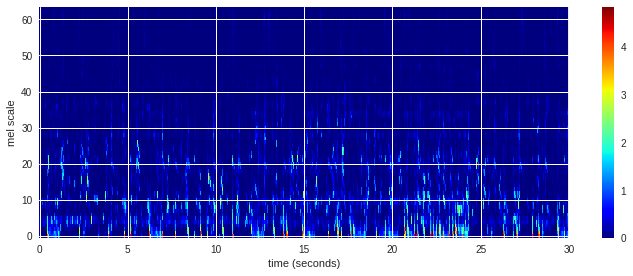

In [21]:
example_mel_spectrogram = mel_spect('/000/000002.mp3')
plt.figure(figsize=(10, 4))
plt.imshow(np.log(example_mel_spectrogram+1), origin="lower", aspect="auto", cmap="jet")
plt.xticks(np.linspace(0, 2587, 7), np.arange(0, 31, 5))
plt.xlabel("time (seconds)"); plt.ylabel("mel scale"); plt.colorbar(); plt.tight_layout()
# plt.savefig("example_mel_spectrogram_colorbar.png", dpi=300)
plt.show()

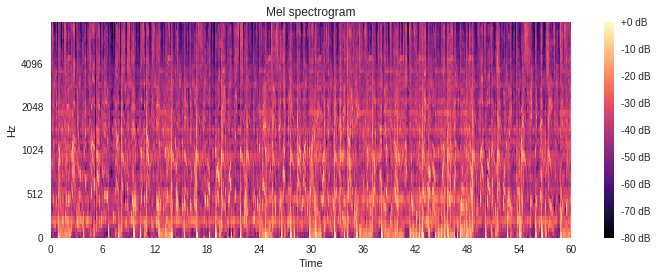

In [22]:
display_spect(mel_spect('/000/000002.mp3'))

We take advantage of this to add another column to our Pandas "tracks" dataframe: the full file name for every track. This helps us create the link between the track and its genre more easily.

In [23]:
# Add the file name to the Pandas dataframe
dir_tracks = {}

for directory in folder_list:
  dir_tracks.update({int(track_name[:-4]): directory + '/' + track_name for track_name in os.listdir('fma_small/%s' % directory)})
  
reduced_tracks['file_name'] = pd.Series(dir_tracks)
reduced_tracks[:10]

,genres,file_name
track_id,,
2,Hip-Hop,000/000002.mp3
5,Hip-Hop,000/000005.mp3
10,Pop,000/000010.mp3
140,Folk,000/000140.mp3
141,Folk,000/000141.mp3
148,Experimental,000/000148.mp3
182,Rock,000/000182.mp3
190,Folk,000/000190.mp3
193,Folk,000/000193.mp3


There is one problem: the Librosa library seems to be **very slow** at loading the audio files, and then at transforming them into mel-spectrograms (2 seconds). For this reason, here is our method:
- We are only going to keep a **smaller fraction of the dataset** (around a thousand songs). It is in this smaller fraction that we pick our train set, validation set, and test set.
- Then, we **precompute** the mel spectrogram for every song: since its output is a basic Numpy array, we can save them to an external file, and then load them again. By doing this, we can make the notebook load the spectrograms ~10 times faster than if we had to compute them.

The folder selection is going to be random, and we obviously initialise the seed in order to get **reproducible results**.

In [24]:
np.random.seed(0)

random_index = np.random.choice(reduced_tracks.index, 1000, replace = False)
small_tracks = reduced_tracks.reindex(random_index).copy()

small_tracks.groupby('genres').agg('count') # Check if distribution is okay

,file_name
genres,
Electronic,136
Experimental,102
Folk,120
Hip-Hop,133
Instrumental,119
International,134
Pop,121
Rock,135


The distribution is fine, so we can use that.

<br/>

Let us now precompute the mel spectrograms once and for all!
- In this case, since the mel spectrograms are basically two-dimensional numpy objects, we choose to store them in **text files**.
- The text files are stored in a separate folder (called `fma_small_np`). Their name depends on the source .mp3 file: for example, the text file "000002.txt" in the `fma_small_np` folder will correspond to the "000002.mp3" file in the `fma_small` folder.

Once the precomputation is done, we want to zip the `fma_small_np` file and store it in a shareable link, in order to exploit it directly in a separate notebook.
- Since the precomputation will last between 40 and 50 minutes – even after drastically reducing the number of songs – we **do not want** to be running this if we do not have to.

In [26]:
source_path = 'fma_small/'
dest_path = 'fma_small_spectrogram/'
problem_tracks = []

start_time = time.time()

if not os.path.exists(dest_path):
  os.makedirs(dest_path)
  
for track_index in small_tracks.index:
  
  try:
    file_spectrogram = mel_spect(small_tracks.loc[track_index].file_name)
    norm_length = file_spectrogram.shape[1] // 10 * 10
    file_spectrogram = np.delete(file_spectrogram, range(norm_length, file_spectrogram.shape[1]), 1)
  
    np.savetxt(dest_path + str(track_index).rjust(6, '0') + '.txt', file_spectrogram)
    
  except KeyboardInterrupt:
    break
    
  except:
    print('Problem with %s' % small_tracks.loc[track_index].file_name)
    problem_tracks += [track_index]

  
  print('Time: %f' % (time.time() - start_time))
  

Time: 1.865402
Time: 3.865928
Time: 5.913415
Time: 7.943378
Time: 9.958908
Time: 12.009979
Time: 14.041287
Time: 16.033433
Time: 18.068660
Time: 20.199022
Time: 22.213987
Time: 24.232823
Time: 26.236356
Time: 28.243084
Time: 30.263283
Time: 32.275194
Time: 34.286652
Time: 36.296051
Time: 38.323192
Time: 40.348014
Time: 42.369929
Time: 44.376227
Time: 46.369081
Time: 48.367140
Time: 50.366326
Time: 52.366241
Time: 54.366891
Time: 56.365939
Time: 58.372464
Time: 60.394335
Time: 62.545279
Time: 64.558491
Time: 66.647714
Time: 68.724956
Time: 70.798686
Time: 72.878401
Time: 74.949497
Time: 77.089052
Time: 79.118387
Time: 81.147896
Time: 83.165719
Time: 85.187234
Time: 87.204758
Time: 89.223806
Time: 91.250526
Time: 93.277092
Time: 95.302866
Time: 97.339151
Time: 99.360816
Time: 101.388442
Time: 103.560332
Time: 105.711011
Time: 107.750440
Time: 109.767000
Time: 111.781602
Time: 113.799266
Time: 115.824354
Time: 117.844636
Time: 119.859736
Time: 121.873990
Time: 123.891327
Time: 125.894339


In [29]:
!zip -r fma_small_spectrogram.zip fma_small_spectrogram

updating: fma_small_spectrogram/ (stored 0%)
  adding: fma_small_spectrogram/109905.txt (deflated 57%)
  adding: fma_small_spectrogram/126187.txt (deflated 57%)
  adding: fma_small_spectrogram/116704.txt (deflated 57%)
  adding: fma_small_spectrogram/122809.txt (deflated 57%)
  adding: fma_small_spectrogram/092951.txt (deflated 57%)
  adding: fma_small_spectrogram/092129.txt (deflated 57%)
  adding: fma_small_spectrogram/004070.txt (deflated 57%)
  adding: fma_small_spectrogram/006394.txt (deflated 57%)
  adding: fma_small_spectrogram/127299.txt (deflated 57%)
  adding: fma_small_spectrogram/145710.txt (deflated 57%)
  adding: fma_small_spectrogram/042046.txt (deflated 56%)
  adding: fma_small_spectrogram/063804.txt (deflated 57%)
  adding: fma_small_spectrogram/031887.txt (deflated 56%)
  adding: fma_small_spectrogram/108014.txt (deflated 56%)
  adding: fma_small_spectrogram/004233.txt (deflated 56%)
  adding: fma_small_spectrogram/064078.txt (deflated 57%)
  adding: fma_small_spectro

In [33]:
!tar -zcvf spectrograms.tar.gz fma_small_spectrogram

fma_small_spectrogram/
fma_small_spectrogram/109905.txt
fma_small_spectrogram/126187.txt
fma_small_spectrogram/116704.txt
fma_small_spectrogram/122809.txt
fma_small_spectrogram/092951.txt
fma_small_spectrogram/092129.txt
fma_small_spectrogram/004070.txt
fma_small_spectrogram/006394.txt
fma_small_spectrogram/127299.txt
fma_small_spectrogram/145710.txt
fma_small_spectrogram/042046.txt
fma_small_spectrogram/063804.txt
fma_small_spectrogram/031887.txt
fma_small_spectrogram/108014.txt
fma_small_spectrogram/004233.txt
fma_small_spectrogram/064078.txt
fma_small_spectrogram/013474.txt
fma_small_spectrogram/105713.txt
fma_small_spectrogram/123762.txt
fma_small_spectrogram/134801.txt
fma_small_spectrogram/125193.txt
fma_small_spectrogram/024702.txt
fma_small_spectrogram/056929.txt
fma_small_spectrogram/013218.txt
fma_small_spectrogram/064631.txt
fma_small_spectrogram/003832.txt
fma_small_spectrogram/081555.txt
fma_small_spectrogram/152545.txt
fma_small_spectrogram/048367.txt
fma_small_spectrogra

In [37]:
!zip -r sample_data.zip sample_data

updating: sample_data/ (stored 0%)
  adding: sample_data/anscombe.json (deflated 83%)
  adding: sample_data/README.md (deflated 41%)
  adding: sample_data/california_housing_test.csv (deflated 76%)
  adding: sample_data/mnist_train_small.csv (deflated 88%)
  adding: sample_data/mnist_test.csv (deflated 88%)
  adding: sample_data/california_housing_train.csv (deflated 79%)


In [40]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
uploaded = drive.CreateFile({'title': 'Colab Notebooks/data/spectrogram/Sample upload.txt'})
uploaded.SetContentFile('fma_small_spectrogram/000207.txt')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

# 3. Load a file by ID and print its contents.
#downloaded = drive.CreateFile({'id': uploaded.get('id')})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

Uploaded file with ID 1HaHsB_KJ2xgzgPYkbCS5wJPerg7ciaMX


In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import shutil
import os

source = 'fma_small_spectrogram/'
dest1 = 'gdrive/My Drive/Colab Notebooks/data/spectrogram'


files = os.listdir(source)

for f in files:
        shutil.move(source+f, dest1)

In [0]:
small_tracks.to_csv('small_tracks.csv')
reduced_tracks.to_csv('reduced_tracks.csv')

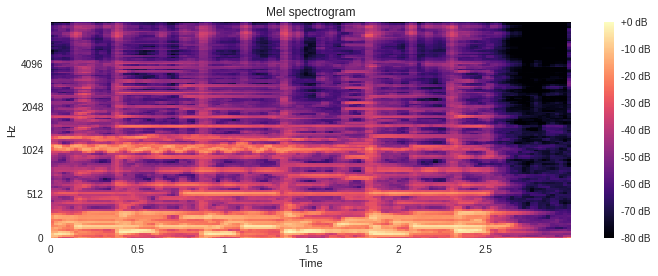

In [224]:
display_spect(np.split(file_spectrogram, 10, 1)[0])

In [0]:
np.random.seed(0)
random_folder_list = list(np.random.choice(folder_list, 22))
random_file_path = [filename for filename in file_paths for foldername in random_folder_list if filename[:3] == foldername]

In [162]:
test_file_path = [int(filename[4:-4]) for filename in random_file_path]
test_tracks = reduced_tracks.reindex(test_file_path)
test_tracks['test'] = 1
test_tracks.groupby('genres').agg('count')

,test
genres,
Electronic,169
Experimental,155
Folk,157
Hip-Hop,133
Instrumental,59
International,65
Pop,144
Rock,132


In [0]:
#save to compressed arrays npz 

#1 load original data 
def load_original_data():
    """
    load original audio files
    :return: X T SR 
    X:list of nparray sound series 
    T: list of sub_folders  ---> list of lables 
    SR: list of sampling rate 
    """
    import os
    data_folder = "/content/fma_small"
    genre_folders = os.listdir(data_folder)
    X = []
    T = []
    SR = []
    min_length = 0
    for sub_folder in genre_folders:
      
      if sub_folder.isdigit():
        
        genre_path = data_folder + "/" + sub_folder
        print(genre_path)
        audio_files = os.listdir(genre_path)
        for audio_name in audio_files:
            audio_path = genre_path + "/" + audio_name
            #x: nparray sound series, sr: sampling rate = 22050
            x, sr = librosa.core.load(audio_path)
            if x.shape[0] < 30 * sr:
                x = np.append(x, np.zeros(30*sr - x.shape[0])) # insure all files are exactly the same length
                if min_length < x.shape[0]:
                    min_length = x.shape[0] # report the duration of the minimum audio clip
                    print("This audio last %f seconds, zeros are padded at the end." % (x.shape[0]*1.0/sr))
            X.append(x[:30*sr])
            SR.append(sr)
            T.append(sub_folder)
    return np.asarray(X), np.asarray(SR), np.asarray(T, dtype=str)

In [138]:
path = 'fma_small_np/'

# 
for folder_name in random_folder_list:
  
  folder_path = 'path/%s' % folder_name
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for file_name in random_file_path:
  
  if not os.path.exists('fma_small_np/%s' % ):
    os.makedirs(directory)
  
  file_spectrogram = mel_spect(path + file_name + '.mp3')
  np.savetxt('fma_small_np/%s.txt' % file_name, file_spectrogram)
  

1014

'024'

In [123]:



start_time = time.time()

src = '000/000002'
np.savetxt('fma_small_np/%s.txt' % src, mel_spect(src + '.mp3'))

#content = {file_path: mel_spect(file_path) for file_path in file_paths[:10]}
print('Time: %f' % (time.time() - start_time))
#content

Time: 2.251240


In [85]:
start_time = time.time()

src = '000/000002'
a = np.loadtxt('fma_small_np/%s.txt' % src)

#content = {file_path: mel_spect(file_path) for file_path in file_paths[:10]}
print('Time: %f' % (time.time() - start_time))
#content

Time: 0.174164


In [88]:
!zip fma_small_np.zip fma_small_np

  adding: fma_small_np/ (stored 0%)


In [63]:
from pydub import AudioSegment

start_time = time.time()

src = '/content/fma_small/000/000002.mp3'

sound = AudioSegment.from_mp3(src)
sound.export('/content/000002.wav', format="wav")

print('Time: %f' % (time.time() - start_time))

Time: 0.494463


In [62]:
start_time = time.time()

mel_spect('000002.wav', path = '/content/')

print('Time: %f' % (time.time() - start_time))

Time: 1.319395


In [37]:
start_time = time.time()

mel_spect('000/000002.mp3')
mel_spect('000/000255.mp3')
mel_spect('000/000256.mp3')

print('Time: %f' % (time.time() - start_time))

Time: 5.820621


In [26]:
mel_spec('000/000255.mp3', False).shape[1]

1291

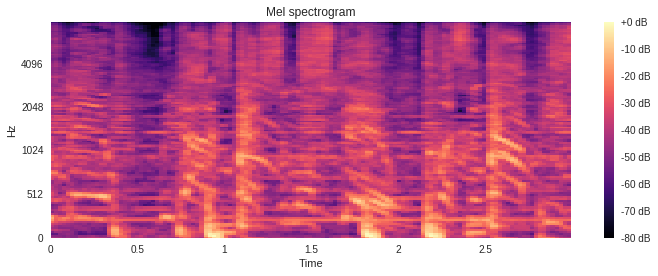

In [111]:
display_spect(np.split(np.delete(mel_spect('000/000002.mp3'), 1290, 1), 10, axis = 1)[1])

array([[1.66139203e+00, 2.91876695e+00, 1.99049625e+00, ...,
        1.23043344e-01, 8.02252690e-01, 1.46043589e+00],
       [1.47544708e+00, 2.89115691e+00, 2.64282714e+00, ...,
        1.13542580e+01, 1.57242097e+01, 3.24317822e+01],
       [1.80672867e+00, 3.91728256e+00, 6.65978966e+00, ...,
        1.60299473e+02, 1.07822607e+02, 1.02646013e+02],
       ...,
       [2.51391871e-05, 7.74222354e-05, 1.15768277e-04, ...,
        6.31023863e-04, 7.57313156e-04, 6.28439965e-04],
       [8.01266288e-06, 1.70406009e-05, 1.98543331e-05, ...,
        2.07523664e-04, 2.33577894e-04, 1.98682164e-04],
       [1.32555962e-06, 2.00051966e-06, 1.63818369e-06, ...,
        1.42191457e-05, 1.60719698e-05, 9.91664107e-05]])

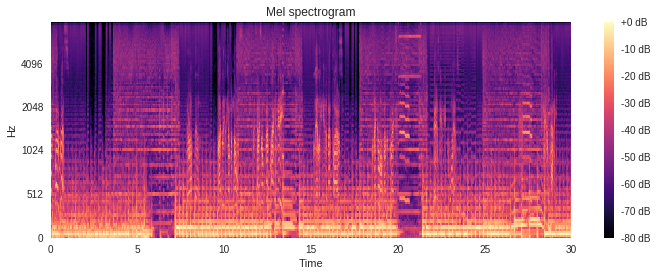

In [24]:
mel_spec('000/000368.mp3')